Summa kostnad i el 2023: 34431902.704115376
Justerad elkostnad simulering: 27096242.099432904


C:\Users\jakob\AppData\Local\Temp\ipykernel_5808\3785277770.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")


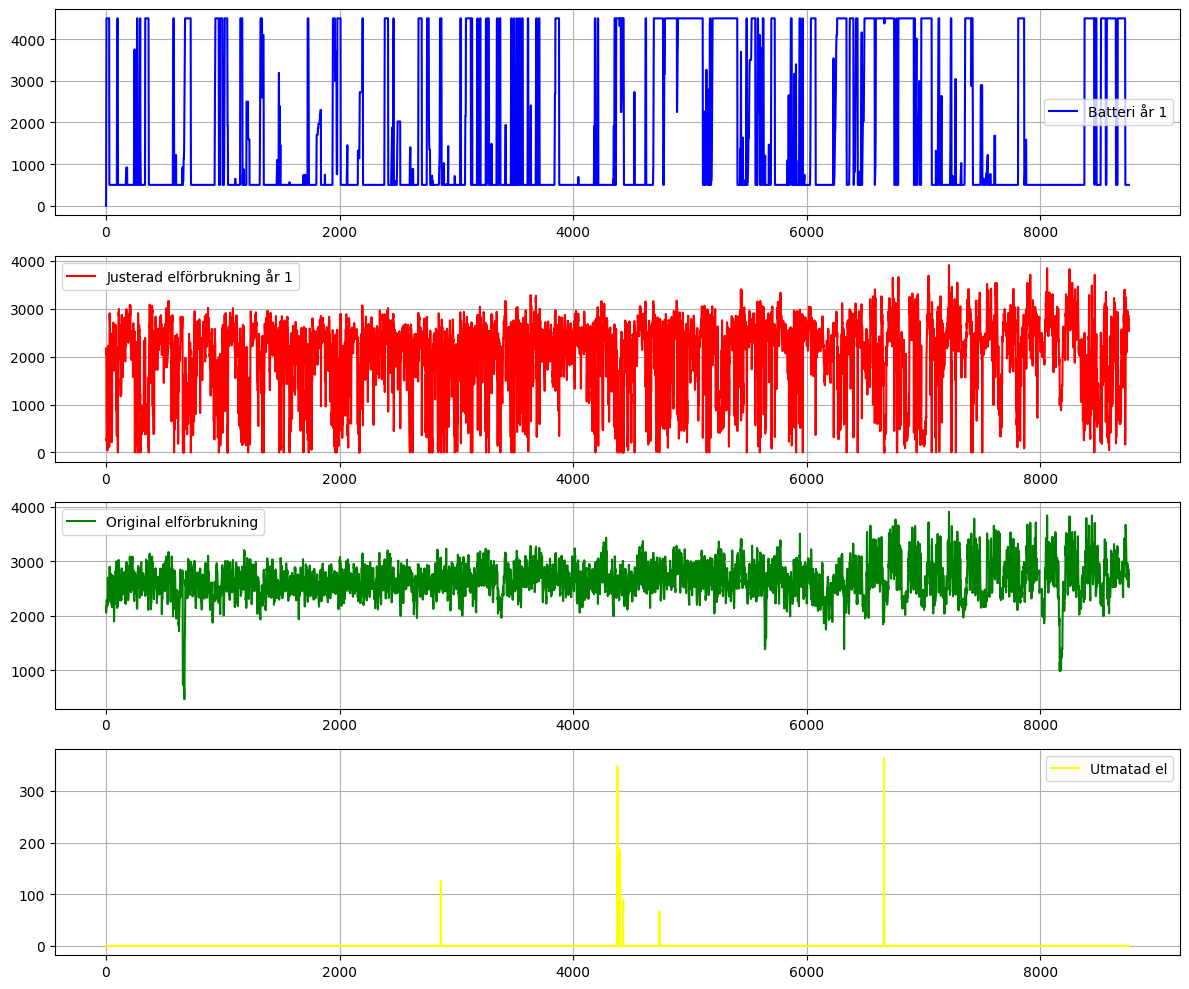

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx")
SödraOmr = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx")

# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.4*Solprod.iloc[:, 0]  # Solel-produktion multipliceras med faktor 0.7 eftersom hela takytan inte används
Spot = Spotpris.iloc[:, 0]
SöOmr = SödraOmr.iloc[:,0]

Prod =   Vind + Sol


elhandelskostnad = (Spot * SöOmr).sum() / 100
energiskatt = (43.9 * SöOmr).sum() / 100

summaElKostnad = (elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)
# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
original_consumption = SöOmr.tolist()
elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for tid, prod, söomr, spot in zip(Spotpris.index, Prod, SöOmr, Spot):  
    diff = söomr - prod  # Skillnad mellan förbrukning och solproduktion

    if diff <= 0:
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)  # -diff eftersom diff är negativ
        elförbrukning.append(0)  # Vi behöver inte köpa el
        utmatning.append(max(0,batteriKapacitet - diff - max_battery_level))
        köptaTimmar.append((tid,0))
    else:
        if spot <= 35 and prod > 0:
            if batteriKapacitet + prod >= max_battery_level: 
                prodÖver = (batteriKapacitet + prod) - max_battery_level
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                köpt_el = max(0, söomr-prodÖver)
                elförbrukning.append(köpt_el)  
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                utmatning.append(0)
            else:
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                elförbrukning.append(söomr)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)  
        elif 35 < spot < 65.75 and prod > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
        elif spot >= 65.75:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, batteriKapacitet-min_battery_level)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            elförbrukning.append(köpt_el)
            utmatning.append(0)
        else:
            elförbrukning.append(söomr)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)


    battery_values.append(batteriKapacitet)


köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='yellow')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

Summa kostnad i el 2023: 34431902.704115376
Original elförbrukning topptimmar:     Timme  Elförbrukning
0    7218       3908.200
1    8058       3843.131
2    8442       3840.423
3    8250       3824.813
4    8394       3794.349
5    7434       3783.307
6    6760       3768.287
7    8441       3756.027
8    7043       3715.430
9    7961       3713.003
10   7914       3707.637
11   8466       3704.873
12   7889       3673.619
13   8731       3670.221
14   6785       3660.640
15   8418       3658.394
16   6545       3655.243
17   7602       3653.145
18   8730       3651.873
19   6928       3648.403
20   7242       3645.646
21   6737       3644.875
22   8059       3635.661
23   6736       3623.693
24   6904       3621.269
25   7913       3594.335
26   8249       3593.372
27   7217       3593.023
28   6713       3584.694
29   6905       3581.508
De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:
1. Timme 2023-10-28 18:00:00  - Förbrukning: 3908.2 (Excel rad: 8)
2. Timme 202

C:\Users\jakob\AppData\Local\Temp\ipykernel_5808\1610049787.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")


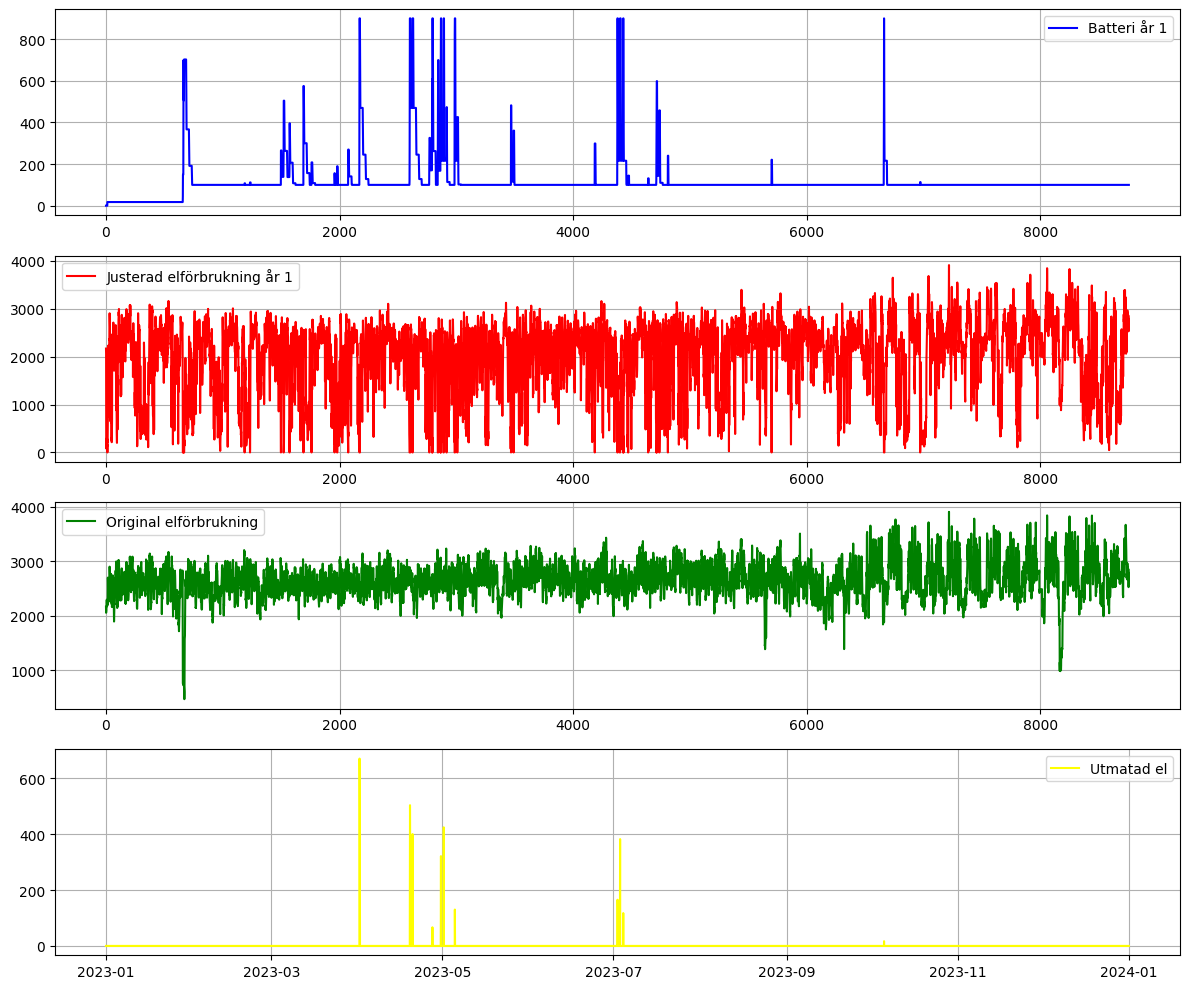

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx")
SödraOmr = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx")

# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.5*Solprod.iloc[:, 0]  # Solel-produktion multipliceras med faktor 0.7 eftersom hela takytan inte används
Spot = Spotpris.iloc[:, 0]
SöOmr = SödraOmr.iloc[:,0]

Prod =   Vind + Sol


elhandelskostnad = (Spot * SöOmr).sum() / 100
energiskatt = (43.9 * SöOmr).sum() / 100

summaElKostnad = (elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(SöOmr)

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)
# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 1000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
original_consumption = SöOmr.tolist()
elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for i, (tid, prod, söomr, spot) in enumerate(zip(Spotpris.index, Prod, SöOmr, Spot)):
    diff = söomr - prod  # Difference between consumption and solar production


    if i < 2800:
        faktor = 0.15
    elif  2500 <= i <= 7500:
        faktor = 0.3
    else:
        faktor = 0.07

    if diff <= 0:
        if batteriKapacitet - diff >= max_battery_level:
            utmatEl = batteriKapacitet - diff - max_battery_level
            utmatning.append((tid, utmatEl))
            batteriKapacitet = max_battery_level  # -diff eftersom diff är negativ
        else:
            utmatning.append((tid, 0))
            batteriKapacitet = batteriKapacitet - diff
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        elförbrukning.append(0)  # Vi behöver inte köpa el
        köptaTimmar.append((tid,0))
    else:  
        
        if 15 <= tid.hour < 19 and prod == 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, söomr - energiFrånBatteri)
            elförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append((tid, 0))
        elif 15 <= tid.hour < 19 and prod > 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            elförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append((tid, 0))
        elif prod > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append((tid,0))
            
        else:
            elförbrukning.append(söomr)  
            köptaTimmar.append((tid, spot))
            utmatning.append((tid, 0))

    
    battery_values.append(batteriKapacitet)


# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(elförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")
for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")


köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
utmatning_tid, utmatning_värde = zip(*utmatning)  # Dela upp tuples i två listor
ax[3].plot(utmatning_tid, utmatning_värde, label='Utmatad el', color='yellow')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()